**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2023 23:59 (GMT+3)</center></h4>

## **CIFAR-100 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the preprocessed CIFAR-100 dataset, which is created for this homework by processing the original [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 28x28 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':

    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-100 dataset is downloadable from [this link](https://drive.google.com/file/d/1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [7]:
import gdown # Library to download files from Google Drive
!gdown 1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL # Google Drive ID of the zip file to be downloaded
!unzip -oq cifar100.zip # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL
To: /content/cifar100.zip
100% 64.1M/64.1M [00:00<00:00, 113MB/s]


### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-100 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [23]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []

        # Load dataset directly in __init__
        for idx, class_folder in enumerate(os.listdir(self.root_dir)):
            class_path = os.path.join(self.root_dir, class_folder)
            label = idx
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                self.image_paths.append(image_path)
                self.labels.append(label)

        # Transformations
        self.transform = transforms.Compose([
            transforms.Resize((32, 32), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, data_id):
        image_path = self.image_paths[data_id]
        label = self.labels[data_id]

        # PIL part
        image = Image.open(image_path).convert('RGB')

        image = self.transform(image)
        return {'image': image, 'label': label}

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [31]:
# CIFAR-100 dataset is in this path
root_directory = '/content/cifar100/test'

# Create training dataset and dataloader
train_dataset = CifarDataset(root_directory)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Create test dataset and dataloader
test_dataset = CifarDataset(root_directory)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-100 images properly.

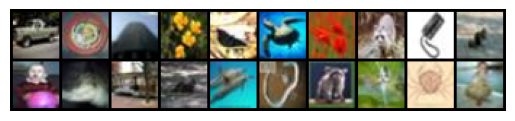

In [33]:
images = next(iter(train_dataloader))["image"] #I needed to call the key of the dictionary ["image"] to pull images
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [36]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # Encoding
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoding
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Use Tanh in the last layer as suggested in the prompt
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [37]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images = batch['image'].to(device)

            # Clone the original image to use it later in the loss function
            original_images = images.clone()

            # Set input tensor columns starting from 16 to 32 as -1 (black pixel)
            images[:, :, :, 16:32] = -1

            # Forward pass
            outputs = model(images)

            # Calculate the loss using the original image as the ground truth
            loss = loss_func(outputs, original_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate the mean loss for the epoch
        epoch_loss /= len(train_dataloader)
        losses.append(epoch_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [46]:
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_dataloader:
            images = batch['image'].to(device)

            # Clone the original image to use it later in the loss function
            original_images = images.clone()

            # Set input tensor columns starting from 16 to 32 as -1 (black pixel)
            images[:, :, :, 16:32] = -1

            # Forward pass
            outputs = model(images)

            # Calculate the Mean Squared Error (MSE) loss using the original image as basis
            loss = torch.nn.functional.mse_loss(outputs, original_images)

            total_loss += loss.item()

    # Calculate the mean loss over all test samples
    mean_loss = total_loss / len(test_dataloader)

    return mean_loss

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [51]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader))["image"] # I also added the ["image"] subscript here to pull image
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



In [40]:
seed_everything(464)
model = CifarAutoencoder()

In [41]:
# Set the initials
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
num_epochs = 50

In [42]:
# Train the model
losses = train_model(model, train_dataloader, optimizer, loss_func, num_epochs)

Epoch 1/50: 100%|██████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch [1/50], Loss: 0.2285


Epoch 2/50: 100%|██████████| 157/157 [00:17<00:00,  9.21it/s]


Epoch [2/50], Loss: 0.1417


Epoch 3/50: 100%|██████████| 157/157 [00:12<00:00, 12.72it/s]


Epoch [3/50], Loss: 0.1293


Epoch 4/50: 100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Epoch [4/50], Loss: 0.1246


Epoch 5/50: 100%|██████████| 157/157 [00:13<00:00, 11.58it/s]


Epoch [5/50], Loss: 0.1220


Epoch 6/50: 100%|██████████| 157/157 [00:12<00:00, 12.32it/s]


Epoch [6/50], Loss: 0.1199


Epoch 7/50: 100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Epoch [7/50], Loss: 0.1182


Epoch 8/50: 100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Epoch [8/50], Loss: 0.1172


Epoch 9/50: 100%|██████████| 157/157 [00:14<00:00, 10.98it/s]


Epoch [9/50], Loss: 0.1155


Epoch 10/50: 100%|██████████| 157/157 [00:16<00:00,  9.24it/s]


Epoch [10/50], Loss: 0.1149


Epoch 11/50: 100%|██████████| 157/157 [00:17<00:00,  8.83it/s]


Epoch [11/50], Loss: 0.1140


Epoch 12/50: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch [12/50], Loss: 0.1134


Epoch 13/50: 100%|██████████| 157/157 [00:14<00:00, 11.19it/s]


Epoch [13/50], Loss: 0.1126


Epoch 14/50: 100%|██████████| 157/157 [00:15<00:00, 10.36it/s]


Epoch [14/50], Loss: 0.1121


Epoch 15/50: 100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Epoch [15/50], Loss: 0.1117


Epoch 16/50: 100%|██████████| 157/157 [00:14<00:00, 10.50it/s]


Epoch [16/50], Loss: 0.1112


Epoch 17/50: 100%|██████████| 157/157 [00:15<00:00, 10.40it/s]


Epoch [17/50], Loss: 0.1112


Epoch 18/50: 100%|██████████| 157/157 [00:12<00:00, 12.09it/s]


Epoch [18/50], Loss: 0.1106


Epoch 19/50: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


Epoch [19/50], Loss: 0.1102


Epoch 20/50: 100%|██████████| 157/157 [00:14<00:00, 10.59it/s]


Epoch [20/50], Loss: 0.1099


Epoch 21/50: 100%|██████████| 157/157 [00:15<00:00,  9.87it/s]


Epoch [21/50], Loss: 0.1096


Epoch 22/50: 100%|██████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch [22/50], Loss: 0.1096


Epoch 23/50: 100%|██████████| 157/157 [00:16<00:00,  9.59it/s]


Epoch [23/50], Loss: 0.1093


Epoch 24/50: 100%|██████████| 157/157 [00:17<00:00,  9.03it/s]


Epoch [24/50], Loss: 0.1090


Epoch 25/50: 100%|██████████| 157/157 [00:13<00:00, 11.76it/s]


Epoch [25/50], Loss: 0.1090


Epoch 26/50: 100%|██████████| 157/157 [00:13<00:00, 11.59it/s]


Epoch [26/50], Loss: 0.1087


Epoch 27/50: 100%|██████████| 157/157 [00:15<00:00, 10.33it/s]


Epoch [27/50], Loss: 0.1087


Epoch 28/50: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s]


Epoch [28/50], Loss: 0.1087


Epoch 29/50: 100%|██████████| 157/157 [00:15<00:00, 10.45it/s]


Epoch [29/50], Loss: 0.1083


Epoch 30/50: 100%|██████████| 157/157 [00:15<00:00, 10.34it/s]


Epoch [30/50], Loss: 0.1079


Epoch 31/50: 100%|██████████| 157/157 [00:15<00:00,  9.82it/s]


Epoch [31/50], Loss: 0.1077


Epoch 32/50: 100%|██████████| 157/157 [00:17<00:00,  8.93it/s]


Epoch [32/50], Loss: 0.1078


Epoch 33/50: 100%|██████████| 157/157 [00:14<00:00, 10.88it/s]


Epoch [33/50], Loss: 0.1078


Epoch 34/50: 100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Epoch [34/50], Loss: 0.1074


Epoch 35/50: 100%|██████████| 157/157 [00:15<00:00,  9.89it/s]


Epoch [35/50], Loss: 0.1073


Epoch 36/50: 100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Epoch [36/50], Loss: 0.1074


Epoch 37/50: 100%|██████████| 157/157 [00:13<00:00, 11.72it/s]


Epoch [37/50], Loss: 0.1069


Epoch 38/50: 100%|██████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch [38/50], Loss: 0.1070


Epoch 39/50: 100%|██████████| 157/157 [00:14<00:00, 10.87it/s]


Epoch [39/50], Loss: 0.1072


Epoch 40/50: 100%|██████████| 157/157 [00:14<00:00, 10.68it/s]


Epoch [40/50], Loss: 0.1066


Epoch 41/50: 100%|██████████| 157/157 [00:15<00:00, 10.26it/s]


Epoch [41/50], Loss: 0.1066


Epoch 42/50: 100%|██████████| 157/157 [00:14<00:00, 10.47it/s]


Epoch [42/50], Loss: 0.1066


Epoch 43/50: 100%|██████████| 157/157 [00:16<00:00,  9.70it/s]


Epoch [43/50], Loss: 0.1067


Epoch 44/50: 100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Epoch [44/50], Loss: 0.1064


Epoch 45/50: 100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Epoch [45/50], Loss: 0.1065


Epoch 46/50: 100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Epoch [46/50], Loss: 0.1063


Epoch 47/50: 100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Epoch [47/50], Loss: 0.1061


Epoch 48/50: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch [48/50], Loss: 0.1060


Epoch 49/50: 100%|██████████| 157/157 [00:17<00:00,  9.14it/s]


Epoch [49/50], Loss: 0.1059


Epoch 50/50: 100%|██████████| 157/157 [00:15<00:00, 10.43it/s]

Epoch [50/50], Loss: 0.1060


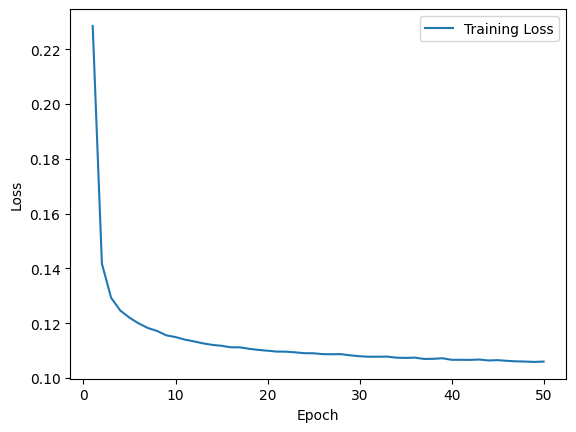

In [43]:
# Visualize the training loss
plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Evaluate the model on the test dataset
test_loss = evaluate_model(model, test_dataloader)
print(f'Mean Square Error on Test Dataset: {test_loss:.4f}')

Mean Square Error on Test Dataset: 0.1046


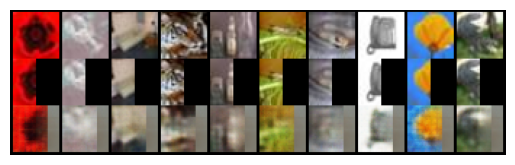

In [52]:
visualize_inpainting(model, test_dataset)